<a href="https://colab.research.google.com/github/alouvre/fish-classification/blob/revision/fish_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setting API Kaggle

In [17]:
# menginstall kaggle
# !pip install -q kaggle

In [33]:
# membuat direktori
!mkdir ~/.kaggle
# menghapus direktori
# !rm -r Fish_Dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# menyalin kaggle.json ke dir kaggle
!cp kaggle.json ~/.kaggle/

In [35]:
# meminta izin untuk akses
!chmod 600 ~/.kaggle/kaggle.json

!kaggle -h

usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
       ...

options:
  -h, --help
    show this help message and exit
  -v, --version
    show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
    Use one of:
    competitions {list, files, download, submit, submissions, leaderboard}
    datasets {list, files, download, create, version, init, metadata, status}
    kernels {list, init, push, pull, output, status}
    config {view, set, unset}
    competitions (c)
    Commands related to Kaggle competitions
    datasets (d)
    Commands related to Kaggle datasets
    kernels (k)
    Commands related to Kaggle kernels
    files (f)
    Commands related files
    config
    Configuration settings


In [36]:
%cd /content/drive/MyDrive/Klasifikasi Ikan

/content/drive/MyDrive/Klasifikasi Ikan


## 1. Importing the Modules

In [86]:
# Import library untuk manipulasi data
import numpy as np
import pandas as pd

# Import library untuk visualisasi data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import library untuk pembagian data (train-test split)
from sklearn.model_selection import train_test_split

# Import library untuk pengolahan gambar
from keras.preprocessing.image import ImageDataGenerator

# Import library untuk machine learning (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import library untuk manipulasi jalur file
from pathlib import Path
import os.path

# Import library khusus untuk tampilan gambar di IPython Notebook
from IPython.display import Image, display

import zipfile

In [87]:
# !kaggle datasets list
# mengunduh dataset
# !kaggle datasets download -d 'crowww/a-large-scale-fish-dataset'

## 2. Loading the Data

In [88]:
# membuat direktori dataset
# !mkdir dataset
# memindahkan files ke direktori dataset
# !mv a-large-scale-fish-dataset.zip dataset

In [89]:
# nama_file_zip = 'a-large-scale-fish-dataset.zip'
# nama_folder_tujuan = 'dataset'

# dataset_zip = zipfile.ZipFile('dataset/a-large-scale-fish-dataset.zip','r')
# dataset_zip.extractall('dataset')
# dataset_zip.close()

In [90]:
# Inisialisasi Direktori Gambar dan Pengambilan Filepaths
image_dir = Path('dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(image_dir.glob(r'**/*.png'))
# Pengambilan Label dari Filepaths
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
# Pengubahan Filepaths dan Labels menjadi Series Pandas
filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)
# Penggabungan Filepaths dan Labels menjadi DataFrame
image_df = pd.concat([filepaths, Labels], axis=1)

# Filtering DataFrame untuk Menghapus Label yang Diakhiri dengan 'GT'
image_df = image_df[image_df['Labels'].apply(lambda x: x[-2:] != 'GT')]

In [91]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(10)

,FilePaths,Labels
0,dataset/Fish_Dataset/Fish_Dataset/Red Mullet/R...,Red Mullet
1,dataset/Fish_Dataset/Fish_Dataset/Red Mullet/R...,Red Mullet
2,dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrim...,Shrimp
3,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
4,dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Br...,Gilt-Head Bream
5,dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Br...,Gilt-Head Bream
6,dataset/Fish_Dataset/Fish_Dataset/Red Sea Brea...,Red Sea Bream
7,dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Br...,Gilt-Head Bream
8,dataset/Fish_Dataset/Fish_Dataset/Red Mullet/R...,Red Mullet
9,dataset/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel


## 2.1 Displaying First 9 Images

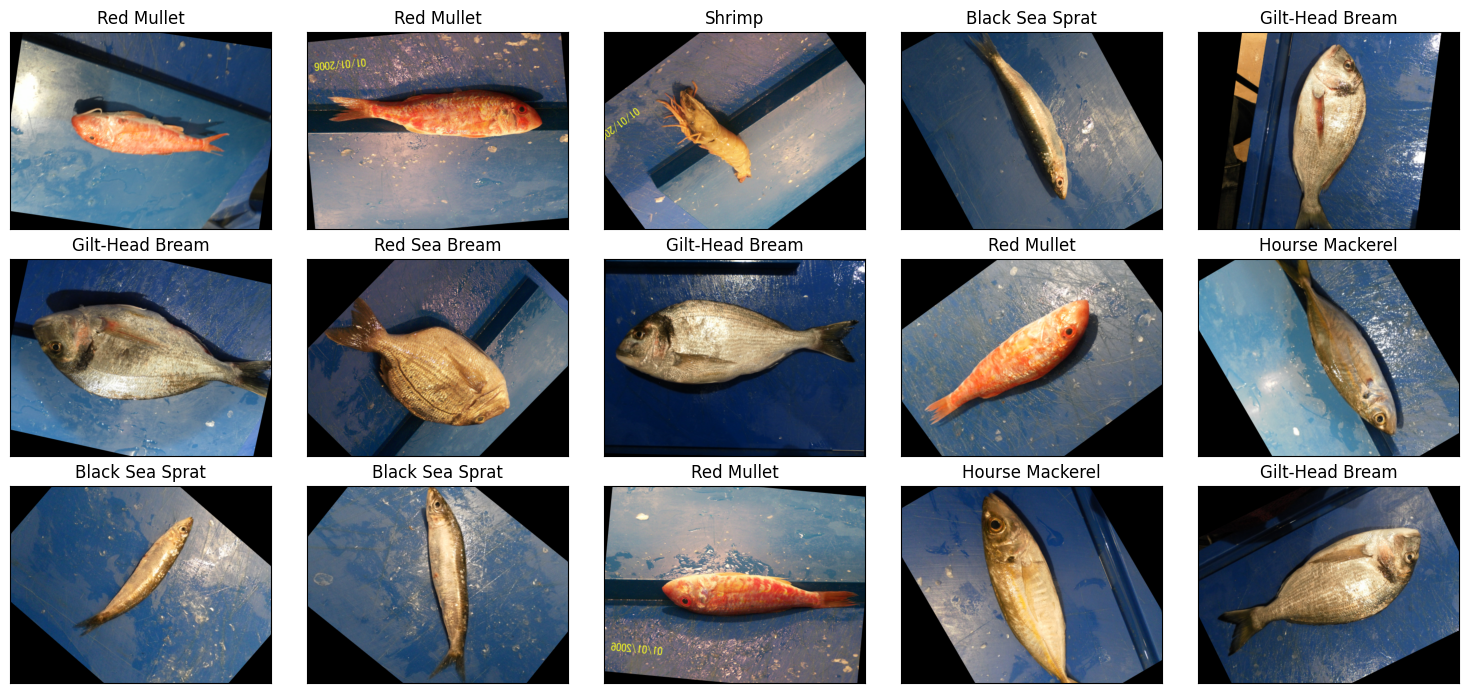

In [92]:
import matplotlib.pyplot as plt
f, a = plt.subplots(nrows=3, ncols=5, figsize=(15,7),
                    subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(a.flat):
  ax.imshow(plt.imread(image_df.FilePaths[i]))
  ax.set_title(image_df.Labels[i])

plt.tight_layout()
plt.show()

## 2.2 Shape of DataFrame

In [93]:
print(f" Count of Rows : {image_df.shape[0]} \n Count of Columns : {image_df.shape[1]}")

 Count of Rows : 7000 
 Count of Columns : 2


## 2.3 Types of Fishes

In [94]:
image_df['Labels'].value_counts(ascending=True)

Red Mullet         1000
Shrimp             1000
Black Sea Sprat    1000
Gilt-Head Bream    1000
Red Sea Bream      1000
Hourse Mackerel    1000
Sea Bass           1000
Name: Labels, dtype: int64

## 3. Splitting the Data

In [95]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.15

x_train, x_test = train_test_split(image_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio))

print(f'Shape of Training data : ', x_train.shape)
print(f'Shape of Testing data : ', x_test.shape)
print(f'Shape of Validation data : ', x_val.shape)
x_testt = x_test.copy()

Shape of Training data :  (5250, 2)
Shape of Testing data :  (1050, 2)
Shape of Validation data :  (700, 2)


## 3.1 Augmenating The Data

In [96]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)

x_train = img_datagen.flow_from_dataframe(dataframe = x_train,
                                          x_col='FilePaths', y_col='Labels',
                                          target_size=img_size, color_mode='rgb',
                                          class_mode='categorical',batch_size=32,
                                          seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test,
                                         x_col='FilePaths', y_col='Labels',
                                         target_size=img_size,color_mode='rgb',
                                         class_mode='categorical',batch_size=32,
                                         seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val,
                                        x_col='FilePaths', y_col='Labels',
                                        target_size=img_size, color_mode='rgb',
                                        class_mode='categorical',batch_size=32,
                                        seed=42)

Found 5250 validated image filenames belonging to 7 classes.
Found 1050 validated image filenames belonging to 7 classes.
Found 700 validated image filenames belonging to 7 classes.


## 3.2 Creating The Model

In [97]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

## 3.3 Training The Model

In [98]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10


InvalidArgumentError: ignored